<a href="https://colab.research.google.com/github/JyothiSupriya/Multi-Model-NLP-Framework-for-Unstructured-Text-Analysis/blob/main/EBIClassProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import nltk

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Upload excel file/CSV

In [ ]:
# Replace with your dataset path
data_path = "/content/Records (1).xlsx"

# Example for a CSV file
df = pd.read_excel(data_path)

# Display the first few rows of the dataset
print(df.head())


                                             Records
0  Jugs of oil found unsecured in aft hydraulic m...
1  First Engineer found Empty aerosol cans mixed ...
2  One Person from terminal was found using his c...
3  Bosun found standing on no.4 hatch coaming tra...
4  1 deck crew not wearing goggles while cleaning...


Remove Duplicates in any column

In [ ]:
# Remove duplicate rows based on all columns
df = df.drop_duplicates()

# Alternatively, remove duplicates based on the text column only
#df = df.drop_duplicates(subset=['Records'])

# Reset index after removing duplicates
df.reset_index(drop=True, inplace=True)

# Check the dataset shape after removing duplicates
print(f"Dataset shape after removing duplicates: {df.shape}")


Dataset shape after removing duplicates: (18, 1)


Remove missing values in any column

In [ ]:
# Drop rows where text column is missing (replace 'text_column' with your column name)
df = df.dropna(subset=['Records'])

# Fill missing values in other columns if needed
df.fillna("", inplace=True)


Convert to Lowercase

In [ ]:
def to_lowercase(text):
    return text.lower()

df['Records'] = df['Records'].apply(to_lowercase)
# Display the first few rows of the dataset
print(df.head())


                                             Records
0  jugs of oil found unsecured in aft hydraulic m...
1  first engineer found empty aerosol cans mixed ...
2  one person from terminal was found using his c...
3  bosun found standing on no.4 hatch coaming tra...
4  1 deck crew not wearing goggles while cleaning...


Remove Noise (Punctuation, Numbers, Special Characters)

In [ ]:
def remove_noise(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)      # Remove numbers
    return text

df['Records'] = df['Records'].apply(remove_noise)


Remove Stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

df['Records'] = df['Records'].apply(remove_stopwords)


Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

df['Records'] = df['Records'].apply(lemmatize_text)


Remove short words(optional)

In [ ]:
def remove_short_words(text):
    return ' '.join([word for word in text.split() if len(word) > 2])

df['Records'] = df['Records'].apply(remove_short_words)

Tokenization

In [ ]:
df['Records'] = df['Records'].apply(word_tokenize)

In [ ]:
print(df.head())


                                             Records
0  [jug, oil, found, unsecured, aft, hydraulic, m...
1  [first, engineer, found, empty, aerosol, can, ...
2  [one, person, terminal, found, using, cellphon...
3  [bosun, found, standing, hatch, coaming, track...
4  [deck, crew, wearing, goggles, cleaning, duct,...


TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine tokens back to sentences for vectorization
df['Records_text'] = df['Records'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features based on your dataset
X = vectorizer.fit_transform(df['Records_text'])


Word2vec

In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model on the tokenized data
w2v_model = Word2Vec(sentences=df['Records'], vector_size=100, window=5, min_count=1, workers=4)

# Generate sentence vectors by averaging word vectors
def vectorize_sentence(tokens, model):
    return np.mean([model.wv[word] for word in tokens if word in model.wv], axis=0)

# Apply vectorization to all records
df['vectorized'] = df['Records'].apply(lambda x: vectorize_sentence(x, w2v_model))

# Drop any NaN rows if they appear
df = df.dropna(subset=['vectorized'])

# Stack vectors for clustering
X = np.vstack(df['vectorized'])


K-means Clustering

                                         Records_text  Cluster
0   jug oil found unsecured aft hydraulic machiner...        2
1   first engineer found empty aerosol can mixed d...        4
2   one person terminal found using cellphone outs...        0
3   bosun found standing hatch coaming track way w...        3
4   deck crew wearing goggles cleaning duct space ...        0
5   whilst checking pilot ladder safely rigged fou...        3
6   sweeping car deck one crew wearing complete pp...        0
7   greasing hatch cover one crew mwmbers climbed ...        3
8   greasing hatch cover one crew mwmbers climbed ...        3
9   found without helmet deckincident brought noti...        3
10  fourth engineer working rescue boat without we...        3
11  deck crew working deck without wearing safety ...        0
12  working aloft secured safety beltrequested imm...        1
13  one crew member found working pipeline safety ...        3
14  deck crew found using power tool without hand ...  

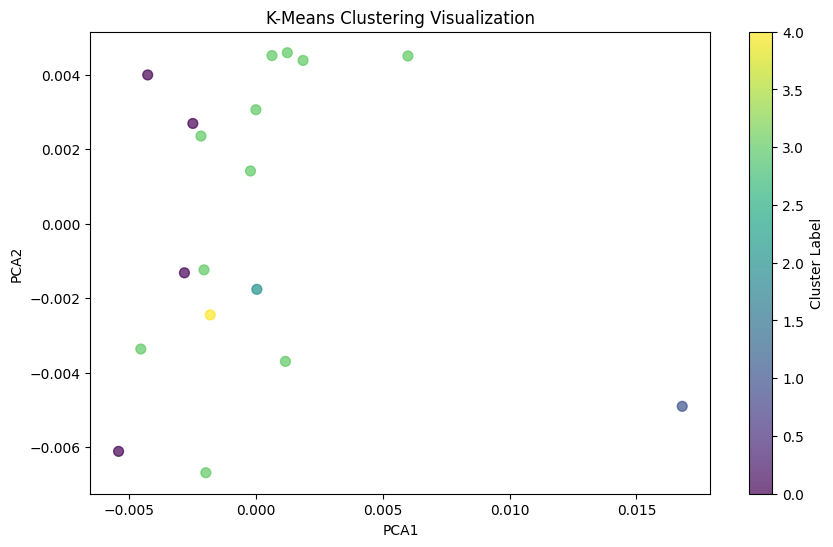

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means
num_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Print cluster labels
print(df[['Records_text', 'Cluster']])

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA components to the DataFrame for visualization
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
# Scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title("K-Means Clustering Visualization")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()



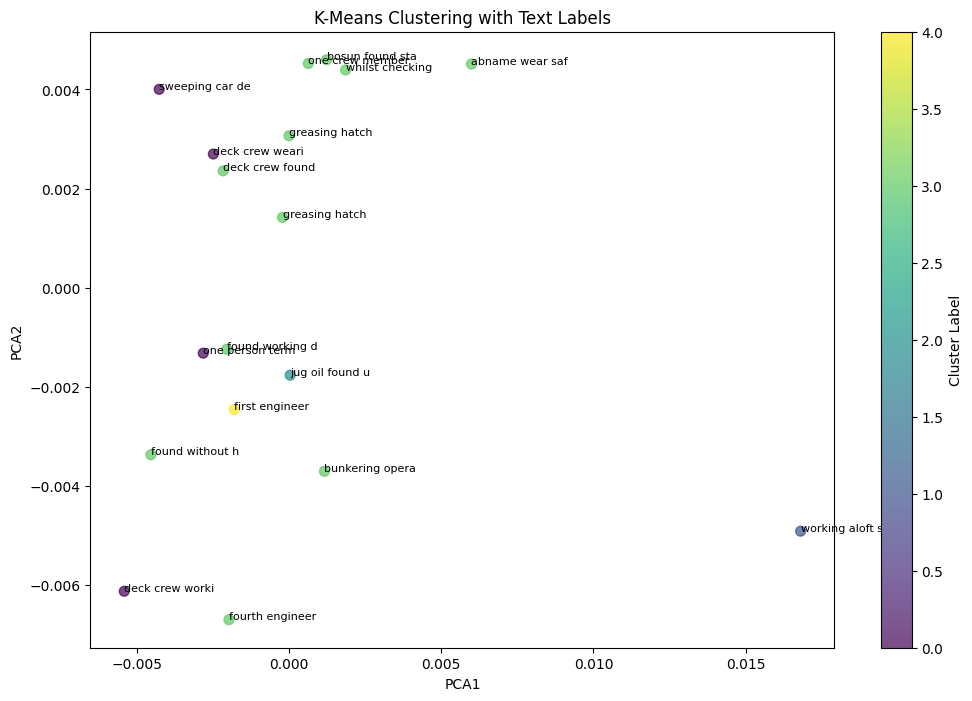

In [ ]:
# Scatter plot with text labels
plt.figure(figsize=(12, 8))
for i in range(len(df)):
    plt.text(df['PCA1'].iloc[i], df['PCA2'].iloc[i], df['Records_text'].iloc[i][:15], fontsize=8)

plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title("K-Means Clustering with Text Labels")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


Hierarchical Clustering

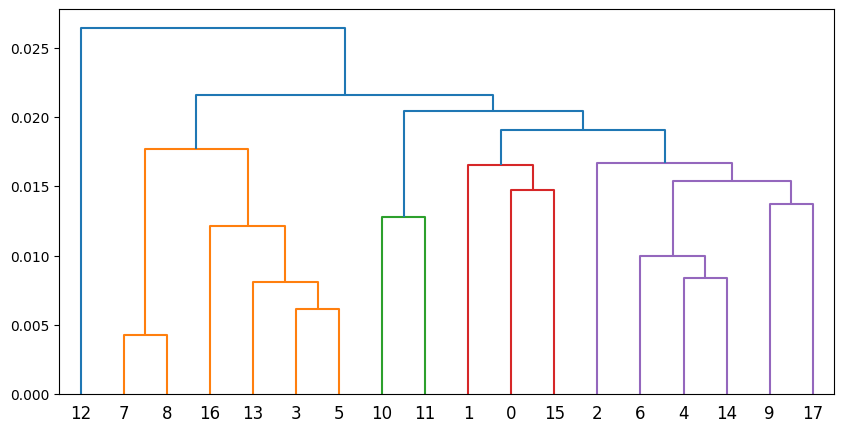

                                         Records_text  Cluster
0   jug oil found unsecured aft hydraulic machiner...        3
1   first engineer found empty aerosol can mixed d...        3
2   one person terminal found using cellphone outs...        4
3   bosun found standing hatch coaming track way w...        1
4   deck crew wearing goggles cleaning duct space ...        4
5   whilst checking pilot ladder safely rigged fou...        1
6   sweeping car deck one crew wearing complete pp...        4
7   greasing hatch cover one crew mwmbers climbed ...        1
8   greasing hatch cover one crew mwmbers climbed ...        1
9   found without helmet deckincident brought noti...        4
10  fourth engineer working rescue boat without we...        2
11  deck crew working deck without wearing safety ...        2
12  working aloft secured safety beltrequested imm...        5
13  one crew member found working pipeline safety ...        1
14  deck crew found using power tool without hand ...  

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Perform hierarchical clustering
# X is already a dense NumPy array, so no need for toarray()
Z = linkage(X, method='ward')  # Use 'ward' for minimal variance

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.show()

# Extract clusters from dendrogram
df['Cluster'] = fcluster(Z, t=5, criterion='maxclust')  # t=number of clusters
print(df[['Records_text', 'Cluster']])

DBSCAN(Density-Based Clustering)

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
df['Cluster'] = dbscan.fit_predict(X)

# Print cluster labels
print(df[['Records_text', 'Cluster']])


                                         Records_text  Cluster
0   jug oil found unsecured aft hydraulic machiner...       -1
1   first engineer found empty aerosol can mixed d...       -1
2   one person terminal found using cellphone outs...       -1
3   bosun found standing hatch coaming track way w...        0
4   deck crew wearing goggles cleaning duct space ...        0
5   whilst checking pilot ladder safely rigged fou...        0
6   sweeping car deck one crew wearing complete pp...        0
7   greasing hatch cover one crew mwmbers climbed ...        0
8   greasing hatch cover one crew mwmbers climbed ...        0
9   found without helmet deckincident brought noti...        0
10  fourth engineer working rescue boat without we...       -1
11  deck crew working deck without wearing safety ...        0
12  working aloft secured safety beltrequested imm...       -1
13  one crew member found working pipeline safety ...        0
14  deck crew found using power tool without hand ...  

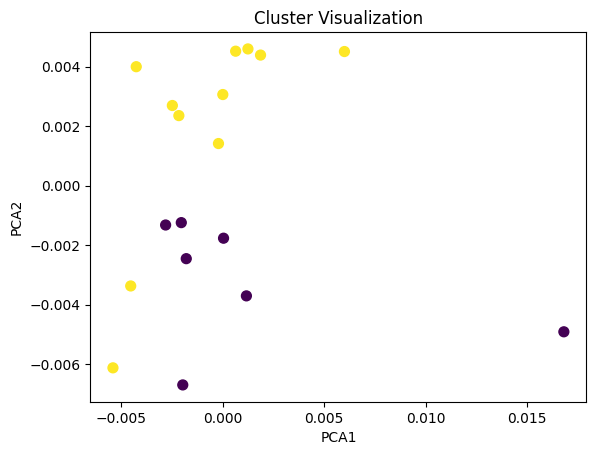

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
# X is already a dense NumPy array, so no need for toarray()
X_pca = pca.fit_transform(X)

# Plot clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', s=50)
plt.title("Cluster Visualization")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np


In [ ]:
# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Records_text'])  # Replace 'Records_text' with the actual column

# Using Count Vectorizer (for LDA)
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
count_matrix = count_vectorizer.fit_transform(df['Records_text'])


In [ ]:
# Number of topics
n_topics = 5

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(count_matrix)

# Extract topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")

no_top_words = 10
display_topics(lda_model, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
crew deck aerosol corrective action proper using incinerator waste engineer


Topic 1:
safety hatch staff proper coaming practice safe working procedure harness


Topic 2:
work safe ppe practice crew job deck tool adequate stop


Topic 3:
working safety ppe deck proper helmet strap use secured order


Topic 4:
aloft safety harness working work requirement strictly qms complied checklist




In [ ]:
# Apply NMF
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Extract topics
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
work safe practice ppe adequate tool job stop complete starting


Topic 1:
hatch safety brief climbed regard trackway concerned ppes cover officer


Topic 2:
deck corrective action master suggested working use ppe engine proper


Topic 3:
aloft safety harness working wear work complied strictly qms requirement


Topic 4:
jug aerosol oil incinerator waste proper rack crew receptaclesinstruct rag




In [ ]:
# Assign dominant topic for LDA
df['LDA_Topic'] = lda_model.transform(count_matrix).argmax(axis=1)

# Assign dominant topic for NMF
df['NMF_Topic'] = nmf_model.transform(tfidf_matrix).argmax(axis=1)

# Display dataset with topics
print(df[['Records_text', 'LDA_Topic', 'NMF_Topic']])


                                         Records_text  LDA_Topic  NMF_Topic
0   jug oil found unsecured aft hydraulic machiner...          2          4
1   first engineer found empty aerosol can mixed d...          0          4
2   one person terminal found using cellphone outs...          0          2
3   bosun found standing hatch coaming track way w...          2          3
4   deck crew wearing goggles cleaning duct space ...          2          0
5   whilst checking pilot ladder safely rigged fou...          4          3
6   sweeping car deck one crew wearing complete pp...          2          0
7   greasing hatch cover one crew mwmbers climbed ...          1          1
8   greasing hatch cover one crew mwmbers climbed ...          1          1
9   found without helmet deckincident brought noti...          1          2
10  fourth engineer working rescue boat without we...          0          2
11  deck crew working deck without wearing safety ...          2          2
12  working 

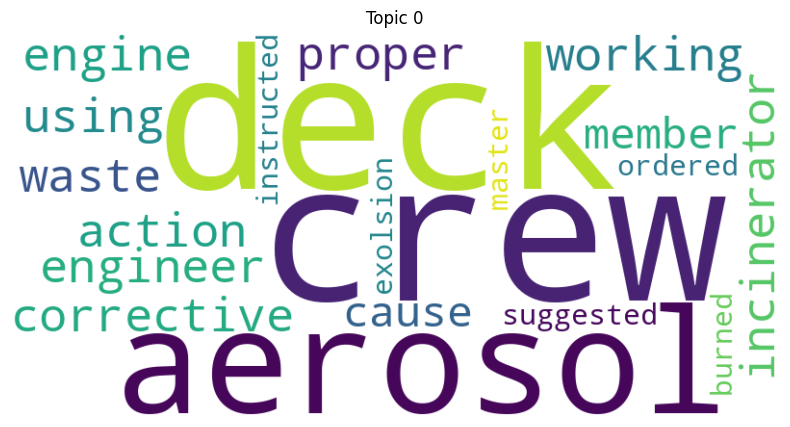

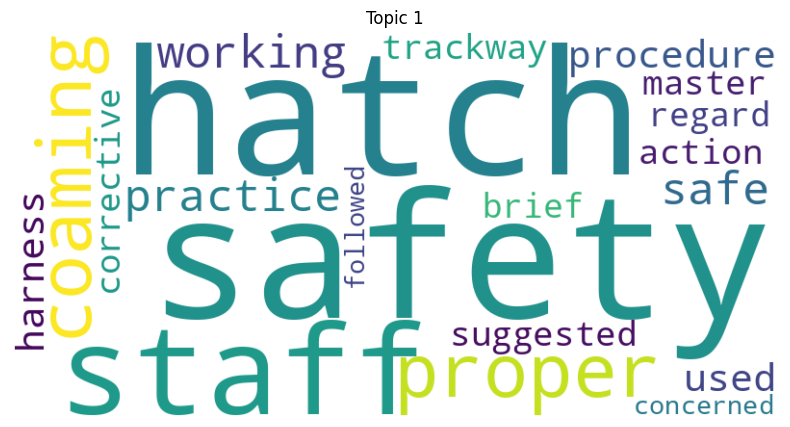

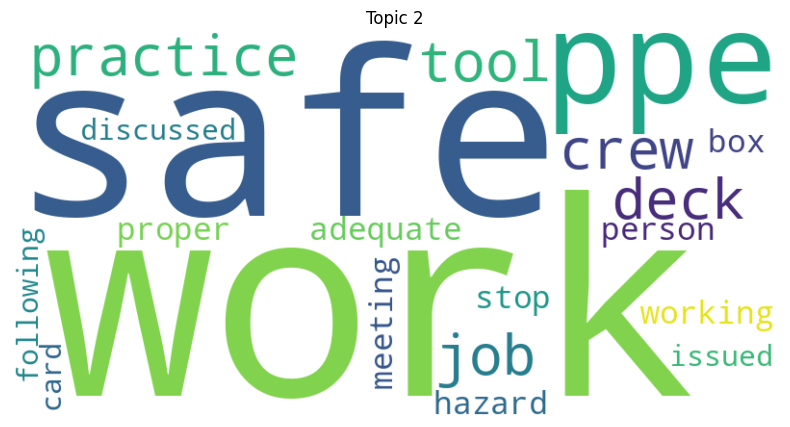

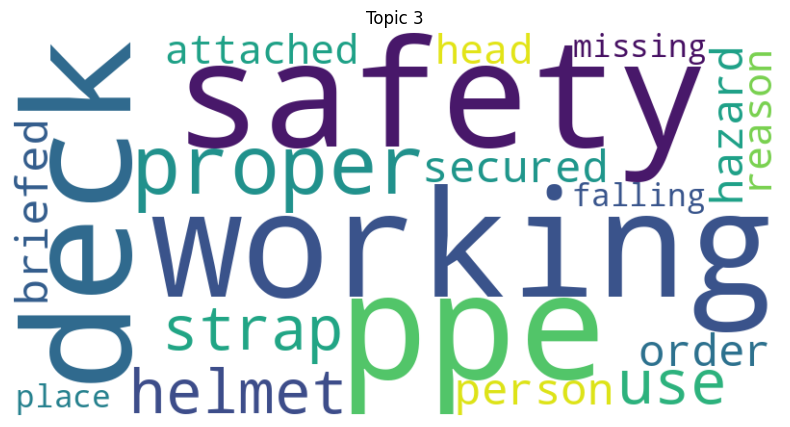

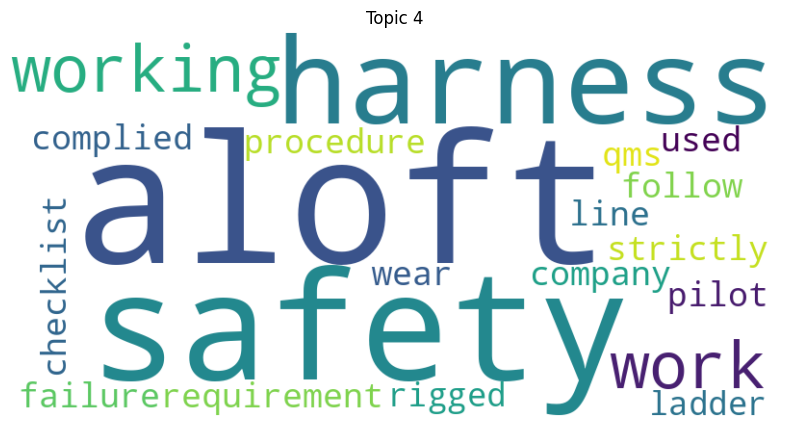

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        " ".join([count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-20 - 1:-1]])
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx}")
    plt.show()
